## Loading the data, padding (based on 2.0)

In [183]:
import sys
import os
import numpy as np
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd


device = torch.device("cpu")   #cuda caused issues on mltgpu

In read_chinese_data I added start and stop tokens to each sentence. Å and Ä are not in the chinese vocabulary so I used them as start and stop tokens. The idea is to later use the start symbol and predict up until the end token.

The start and stop token are also given values of 1 as labels for the segmentation model, to keep the match between label values the same when adding tokens.

In [184]:
def read_chinese_data(inputfilename):
    with open(inputfilename, "r") as inputfile:
        
        #å and ä not found in chinese dataset
        start_token = "å"
        stop_token = "ä"
        
        sentences = []
        
        #always starts with a start token
        collection_words = [start_token, stop_token]
        
        collection_labels = []
        for line in inputfile:
            if line[0] == '#':
                continue
            columns = line.split()
            if columns == []:
                
                #add and insert collection labels
                collection_labels.append(1)
                collection_labels.insert(1,1)
                sentences.append((''.join(collection_words), collection_labels))
                
                #next collection of words is start and stop
                collection_words = [start_token, stop_token]
                collection_labels = []
                continue
            #insert characters between start and stop tokens
            collection_words.insert(1, columns[1])
            collection_labels += [1] + ([0] * (len(columns[1]) - 1))
            
    
    return sentences

In [185]:
train_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-train.conllu')

In [186]:
test_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-test.conllu')

In [187]:
print(train_sentences[0])

('å。自己還是的決定最後，追根究底但，意見的不同你給著試，好友親朋的周遭你是的代表他們其實但，決擇做一選二是只，簡單看似ä', [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1])


In [188]:
def index_chars(sentences):
    megasentence = ''.join(sentences)
    char_list = set()
    for c in megasentence:
        char_list.add(c)
    char_list = [0] + list(char_list)
    return char_list, {char_list[x]:x for x in range(len(char_list))}

In [8]:
int_index, char_index = index_chars([x[0] for x in train_sentences + test_sentences])

In [9]:
char_index["ä"]

214

In [10]:
char_index["å"]

967

In [189]:
def convert_sentence(sentence, index):
    return [index[x] for x in sentence]

In [190]:
def pad_lengths(sentences, max_length, padding=0):
    return [x + ([padding] * (max_length - len(x))) for x in sentences]


In [191]:
def create_dataset(x, device=device):
    converted = [(convert_sentence(x1[0], char_index), x1[1]) for x1 in x]
    X, y = zip(*converted)
    lengths = [len(x2) for x2 in X]               #true lengths of sentence up to the padding
    padded_X = pad_lengths(X, max(lengths))
    Xt = torch.LongTensor(padded_X).to(device)
    padded_y = pad_lengths(y, max(lengths), padding=-1)
    yt = torch.LongTensor(padded_y).to(device)
    lengths_t = torch.LongTensor(lengths).to(device)
    return Xt, lengths_t, yt

In [192]:
train_X_tensor, train_lengths_tensor, train_y_tensor = create_dataset(train_sentences, device)
test_X_tensor, test_lengths_tensor, test_y_tensor = create_dataset(test_sentences, device)

In [193]:
class Batcher:
    def __init__(self, X, lengths, y, device, batch_size=50, max_iter=None):
        self.X = X
        self.lengths = lengths # We need the lengths to efficiently use the padding.
        self.y = y
        self.device = device
        self.batch_size=batch_size
        self.max_iter = max_iter
        self.curr_iter = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_iter == self.max_iter:
            raise StopIteration
        permutation = torch.randperm(self.X.size()[0], device=self.device)
        permX = self.X[permutation]
        permlengths = self.lengths[permutation]
        permy = self.y[permutation]
        splitX = torch.split(permX, self.batch_size)
        splitlengths = torch.split(permlengths, self.batch_size)
        splity = torch.split(permy, self.batch_size) 
        
        self.curr_iter += 1
        return zip(splitX, splitlengths, splity)

In [200]:
#original segmentation model
import torch.nn as nn

class Segmenter(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0)
        self.lstm = nn.LSTM(self.emb_size, 150, batch_first=True)
        self.sig1 = nn.Sigmoid()
        self.lin = nn.Linear(150, 2)
        self.softmax = nn.LogSoftmax(2)
        
    def forward(self, x, lengths):
        embs = self.emb(x)
        packed = pack_padded_sequence(embs, lengths.to("cpu"), batch_first=True, enforce_sorted=False)
        output1, _ = self.lstm(packed)
        unpacked, _ = pad_packed_sequence(output1, batch_first=True)
        output2 = self.sig1(unpacked)
        output3 = self.lin(output2)
        return self.softmax(output3)

In the generator model I first changed the linear layer since we are no longer predicting on two classses. The model should predict on the entire vocabulary, I therefore removed the sigmoid layer since I am using cross entropy loss to train the model which has a built in softmax and expects unnormalized logits as input.


In [201]:
#generation model
class Generator(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0)
        self.lstm = nn.LSTM(self.emb_size, 150, batch_first=True)       #lstm computes for each element in input sequence
        self.sig1 = nn.Sigmoid() 
        self.lin = nn.Linear(150, vocab_size)                           #predict on vocabulary size instead of 2 classes
        self.logsoftmax = nn.LogSoftmax(2)                              
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, lengths):
        embs = self.emb(x)
        packed = pack_padded_sequence(embs, lengths.to("cpu"), batch_first=True, enforce_sorted=False)  
        output1, *_ = self.lstm(packed)
        unpacked, _ = pad_packed_sequence(output1, batch_first=True)
        output = self.lin(unpacked)                     #linear layer to vocab size
        return output                                   
        

In the dual objective model (Generator_Segmenter) the output is a tuple where tuple[0] corresponds to the generation objective and tuple[1] corresponds to the the segmentation objective. 

self.gen is a linear layer from the output of the LSTM to the vocabulary size while self.seg is an a linear layer from the lstm with a binary classification for if a character is the start of a word or not.

The generation and segmentation tasks both go through the same process at first in packed, lstm and unpacked. After this process the generation goes through its linear layers and is outputted as it is since it goes to a crossentropyloss which expects logits. 

The segmentation task is put through linear layers, then a logsoftmax and then to an NLLLoss.

I could have just used the same lossfunction since logsoftmax + nllloss is equivalent to untampered with logits and crossentropyloss.

In [204]:
class Generator_Segmenter(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0)
        self.lstm = nn.LSTM(self.emb_size, 150, batch_first=True)       #lstm computes for each element in input sequence
        self.sig1 = nn.Sigmoid() 
        self.gen = nn.Linear(150, vocab_size)                           #predict on vocabulary size
        self.seg = nn.Linear(150, 2)                                   #predict on word boundary
        self.logsoftmax = nn.LogSoftmax(2)
        
    def forward(self, x, lengths):
        embs = self.emb(x)
        packed = pack_padded_sequence(embs, lengths.to("cpu"), batch_first=True, enforce_sorted=False)  
        output1, *_ = self.lstm(packed)
        unpacked, _ = pad_packed_sequence(output1, batch_first=True)  
        
        #generation
        generation = self.gen(unpacked)
        
        #segmentation
        segmentation = self.sig1(unpacked)
        segmentation = self.seg(segmentation)
        segmentation = self.logsoftmax(segmentation)
        
        return generation, segmentation
        

The dual objective model outputs a tuple of generation and segmentation, NLLLoss is used for the segmentation. 

For the generation the entire sequence is shifted by one character so that the model predicts on the next character. To accomplish this the last character from the predictions is removed before the loss function WHY
and the start token is removed from the sequence used as labels to compare to.

The losses are added together and backpropagation is done on this combined loss.

In [205]:
def train_seg(X, lengths, y, vocab_size, emb_size, batch_size, epochs, device, model=None):
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    if not model:
        m = Segmenter(vocab_size, emb_size).to(device)
    else:
        m = model
    loss = nn.NLLLoss(ignore_index=-1)
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            o = m(batch[0], batch[1])
            l = loss(o.permute(0,2,1), batch[2][:, :max(batch[1])])
            tot_loss += l
            l.backward()
            optimizer.step()
        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
    return m

In [206]:
def train_seg_gen(X, lengths, y, vocab_size, emb_size, batch_size, epochs, device, model=None):
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    if not model:
        m = Generator_Segmenter(vocab_size, emb_size).to(device)
    else:
        m = model
    loss1 = nn.NLLLoss(ignore_index=-1)
    loss2 = nn.CrossEntropyLoss()
    optimizer = optim.Adam(m.parameters(), lr=0.005)   
    epoch = 0
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            
            
            #model outputs for gen and seg objectives
            gen, seg = m(batch[0], batch[1])
            
            #segmentation
            l = loss1(seg.permute(0,2,1), batch[2][:, :max(batch[1])])
            
            #generation
            labels = batch[0]
            gen = gen[:, :-1, :]                #remove last token
            labels = labels[:, 1:max(batch[1])] #remove start token
            
            
            l2 = loss2(gen.permute(0,2,1), labels)      #crossentropyloss on unnormalized scores

            
            all_losses = l + l2                         #combined loss
            
            tot_loss += all_losses                      
            all_losses.backward()                       #backwards pass on both losses
            optimizer.step()
        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
    return m

For the train generator, I added a start and stop token to the training data and the model predicts from the start token up until 

**Same as in previous markdown**
For the generation the entire sequence is shifted by one character so that the model predicts on the next character. To accomplish this the last character from the predictions is removed before the loss function WHY
and the start token is removed from the sequence used as labels to compare to.


The difference in only generation is in the loss function which is only cross entropy loss instead of both cross entropy loss and NLLLoss on two objectives.




In [24]:

def train_generator(X, lengths, y, vocab_size, emb_size, batch_size, epochs, device, model=None):
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    if not model:
        m = Generator(vocab_size, emb_size).to(device)
    else:
        m = model
    loss2 = nn.CrossEntropyLoss(ignore_index=0)       #maybe add ignore index?
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            
            
            
            input_length = batch[1]
            input_sentence = batch[0]
            
            
            output = m(input_sentence, input_length)  
            

            labels = batch[0]

            output = output[:, :-1, :]          #remove last token
            labels = labels[:, 1:max(batch[1])] #remove start token
            
            
            
            l = loss2(output.permute(0,2,1), labels)
            
            
            tot_loss += l
            l.backward()
            optimizer.step()

        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
    return m

In [78]:
#generation and segmentation model training
model_genseg = train_seg_gen(train_X_tensor, train_lengths_tensor, train_y_tensor, len(int_index), 200, 50, 60, device)
torch.save(model_genseg.state_dict(), "model_genseg")

Total loss in epoch 0 is 628.220703125.
Total loss in epoch 1 is 564.6466674804688.
Total loss in epoch 2 is 516.5951538085938.
Total loss in epoch 3 is 473.12908935546875.
Total loss in epoch 4 is 432.0235900878906.
Total loss in epoch 5 is 391.45159912109375.
Total loss in epoch 6 is 352.3448486328125.
Total loss in epoch 7 is 316.02117919921875.
Total loss in epoch 8 is 281.5361022949219.
Total loss in epoch 9 is 250.3479766845703.
Total loss in epoch 10 is 222.35533142089844.
Total loss in epoch 11 is 201.13719177246094.
Total loss in epoch 12 is 185.2348175048828.
Total loss in epoch 13 is 172.23960876464844.
Total loss in epoch 14 is 162.32562255859375.
Total loss in epoch 15 is 155.9208221435547.
Total loss in epoch 16 is 149.55648803710938.
Total loss in epoch 17 is 144.77838134765625.
Total loss in epoch 18 is 139.172119140625.
Total loss in epoch 19 is 136.1271209716797.
Total loss in epoch 20 is 133.36387634277344.
Total loss in epoch 21 is 130.353759765625.
Total loss in ep

In [73]:
#generation model training
modelgen = train_generator(train_X_tensor, train_lengths_tensor, train_y_tensor, len(int_index), 200, 50, 60, device)
torch.save(modelgen.state_dict(), "model_gen")

Total loss in epoch 0 is 504.263427734375.
Total loss in epoch 1 is 435.24029541015625.
Total loss in epoch 2 is 400.94140625.
Total loss in epoch 3 is 377.34576416015625.
Total loss in epoch 4 is 358.65948486328125.
Total loss in epoch 5 is 342.72723388671875.
Total loss in epoch 6 is 328.790771484375.
Total loss in epoch 7 is 316.0815124511719.
Total loss in epoch 8 is 304.4854431152344.
Total loss in epoch 9 is 293.5755615234375.
Total loss in epoch 10 is 283.7752990722656.
Total loss in epoch 11 is 274.3225402832031.
Total loss in epoch 12 is 265.67193603515625.
Total loss in epoch 13 is 257.06195068359375.
Total loss in epoch 14 is 249.74961853027344.
Total loss in epoch 15 is 242.2928466796875.
Total loss in epoch 16 is 235.35182189941406.
Total loss in epoch 17 is 229.05992126464844.
Total loss in epoch 18 is 222.83351135253906.
Total loss in epoch 19 is 217.05868530273438.
Total loss in epoch 20 is 211.8186492919922.
Total loss in epoch 21 is 206.92022705078125.
Total loss in e

In [ ]:
#segmentation training
model_seg = train_seg(train_X_tensor, train_lengths_tensor, train_y_tensor, len(int_index), 200, 50, 60, device)
torch.save(model_seg.state_dict(), "model_seg")

## Evaluation

In [25]:
#generator and segmenter

model_seg_gen = Generator_Segmenter(vocab_size=len(int_index), emb_size=200)
model_seg_gen.load_state_dict(torch.load("model_genseg"))
model_seg_gen.eval()

with torch.no_grad():
    rawpredictions = model_seg_gen(test_X_tensor, test_lengths_tensor) #outputs tuple
    generator_preds = rawpredictions[0]
    segmentor_preds = rawpredictions[1]


#segmenter

modelseg = Segmenter(vocab_size=len(int_index), emb_size=200)
modelseg.load_state_dict(torch.load("model_seg"))
modelseg.eval()

with torch.no_grad():
    rawpredictions = modelseg(test_X_tensor, test_lengths_tensor)
    only_segmentor_preds = rawpredictions
    
    
    
model_gen = Generator(vocab_size=len(int_index), emb_size=200)
model_gen.load_state_dict(torch.load("model_gen"))
model_gen.eval()

In [26]:


#predictions
def test(segpreds, modelname):
    segpreds = torch.argmax(segpreds, 2)
    
    collectpreds = []
    collecty = []
    for i in range(test_X_tensor.size(0)):
        collectpreds.append(segpreds[i][:test_lengths_tensor[i]])
        collecty.append(test_y_tensor[i][:test_lengths_tensor[i]])
    
    allpreds = torch.cat(collectpreds)
    classes = torch.cat(collecty)
    classes = classes.float()
    allpreds = allpreds.float()
    
    tp = sum(classes * allpreds)
    fp = sum(classes * (~allpreds.bool()).float())
    tn = sum((~classes.bool()).float() * (~allpreds.bool()).float())
    fn = sum((~classes.bool()).float() * allpreds)
    
    tp, fp, tn, fn

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = (2 * recall * precision) / (recall + precision)
    return print("model: {}\t accuracy: {:.2f}\t recall: {:.2f}\t precision: {:.2f}\t f1:{:.2f}".format(modelname, accuracy,recall,precision,f1))

#converges after 53 epochs
preds_segmentor = test(only_segmentor_preds, "segmentor")

#do not converge withint 60 epochs
preds_genseg = test(segmentor_preds, "seg n gen")



model: segmentor	 accuracy: 0.58	 recall: 0.65	 precision: 0.76	 f1:0.70
model: seg n gen	 accuracy: 0.58	 recall: 0.65	 precision: 0.75	 f1:0.70


In [30]:
from random import sample
start_token = char_index["å"]
second_token = char_index["。"]
stop_token = char_index["ä"]


#generate random length sentences
def generator(num_sentences, max_length, modelname):
    
    thirdtensors = []
    for i in range(len(test_X_tensor)):
        thirdtensors.append(test_X_tensor[i][2])
        

    listofpreds = []
    
    length = torch.tensor(max_length).to(device)         #change to generate different lengths
    length = length.long()
    length = length.unsqueeze(0)
    
    #currently generating random seeds inside the model, otherwise output is the same x amount of different sentences
    
    with torch.no_grad():
        for i in range(num_sentences):
            one_sample = sample(thirdtensors, 1)
            sent = torch.zeros(length).to(device)
            sent[0] = torch.tensor(start_token).to(device)  #start token
            sent[1] = torch.tensor(one_sample).to(device)  #second token
            sent = sent.long()
            sent = sent.unsqueeze(0)                 #add batch index
            
            for j in range(50 -2):
                out = modelname(sent, length)
                #print(len(out))
                if len(out) > 1:
                    out = out[0]           #if combined model, use generator

                out = out.squeeze(0)        #remove batch index
                out = torch.argmax(out, 1)  #highest probability of word
                
                sent = sent.squeeze(0)
                sent[j+2] = out[j+2]               #i+2 because start token as input and random seed 
                sent = sent.unsqueeze(0)          #add batch index
                
                
                #add stop condition if character is stop token

                    

            sentence = [str(int_index[x]) for x in out]
            listofpreds.append("".join(sentence))
            
            
            
    
    return listofpreds




test_preds_gen = generator(num_sentences=5, max_length=60, modelname = model_gen)

In [31]:
test_preds_seg_gen = generator(num_sentences=5, max_length=60, modelname = model_seg_gen)

In [32]:
#weirdly exactly the same output...


for i in range(len(test_preds_gen)):
    print("only generation\n {}\n".format(test_preds_gen[i]))

print("--------------------------------------------------------------")

for i in range(len(test_preds_seg_gen)):
    print("generation and segmentation\n {}\n".format(test_preds_seg_gen[i]))

only generation
 n提郗醣辯峯焚僕典鼩恰構肇式斯釘蚩橙鍋咐玩J構磅芻無癮牲級肇吩利嚇農銓農碎虢費天怒夠習硫霧猜昂汞硫式式嘉釘扣釘嘈釘嘈釘瀏

only generation
 n錄撲罹睹又綿斯鑽甩徒諧葡克斯殆斯續搶潤渚褐廷牲雅潔汶歌猜磺派派蟒眯天亞網閃柱効典痛齧脆轍醺釘演前舖磺習卓式卓釘卓釘卓釘

only generation
 nB屏啟閉充厥晤揚划攻擢顯理腿項賦老昌長躬刻吋駛臨麗鱺瑋遜浸面尖前便枝枝枝枝莉針齋齋齋齋針針針針針閃閃閃閃閃閃邪閃鬼閃灶

only generation
 n霞譯帽嫻徒桓諒啄肇塘四式典茸冒甥撞結Q利利撐雜醬式臨煦貂搶任檄庚古昂甥瘧橡諒芳啄玷郝老豢錯頂渚搶邪椎式駕釘漳釘靴釘愛釘

only generation
 n勾h熾庄繽毀聆陝減賠芻搶鰭麓翁當萎瀋地杳梵徙凹枚肌羨入臨薺悔忽搶僕穴明雲霧搶潤長（式宗賦賜兢宙天式壇釘磺式腿釘扣釘腿釘

--------------------------------------------------------------
generation and segmentation
 泛000掘繽巢羞渲渲蝶9枯菜蚺疼熄°祠寨播符兒撰柢崇歩池0符簧削謝集穴蝶暫騏桑恰耀仔霾0符坊符阪書鄂卡削輻削嚮削鄂削澱削

generation and segmentation
 泛00000000000000000000000000000000000000000000000000000000000

generation and segmentation
 泛0000枸傾枸枸路路傾敘路路亨冷路蚺批根甚亨換搬墳盾巫墳盾州馮基基鈺宴基基鈺搏基鈺搏基鈺搏基鈺搏墳44廢鄂鄂鄂削鄂削截

generation and segmentation
 泛凌0熄簧簧氘0拆0嘎廖鄂日輔歡頻鶉推饃午給煮卡培擂訟泄爭供閉0符0拆0哇樟耀瀑供濃統富釋腺趨辯謝削頻鄂暴鄂暴削悉削截削

generation and segmentation
 泛0覆000000000000000000000000000000000000000000000000000000000



In [34]:
#perplexity


#probably wrong
def perplexity(testdata, lengths, modelname):
    
    crossloss = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        
        #labels = testdata
        labels = testdata
        labels = labels[:, 1:max(lengths)]    #remove first word and zeros
        
        out = modelname(testdata, lengths)
        
        if modelname == model_seg_gen:
            out = out[0]
            preds = out[:, :-1, :]          #remove last word
            loss = crossloss(preds.permute(0,2,1), labels) 
        else:
            preds = out[:, :-1, :]       #remove last word
            loss = crossloss(preds.permute(0,2,1), labels) 
                        
        print("-------------------------")
    return print("perplexity: {}".format(torch.exp(loss)))



#too big of a difference? doesnt make sense
perplexity_seg_gen = perplexity(test_X_tensor, test_lengths_tensor, model_seg_gen)
perplexity_gen = perplexity(test_X_tensor, test_lengths_tensor, model_gen)




-------------------------
perplexity: 145.3295440673828
-------------------------
perplexity: 45542.375


**Embedding exploration**



For the exploration of the embeddings of characters at the beginning of words and other characters I tried two different approaches. The embeddings are taken for each word from the generation model and turned into tensors then numpy arrays.


First approach: Principal component analysis (PCA). PCA takes the biggest predictive features from the 200 dimension embedding, the predictive value was quite low for these however, around 4-5 percent for both start tokens and other tokens.

The plotting is done based on the two most predictive values from each embedding.



Second approach: Singular value decomposition (SVD), although SVD might not suit this task very well since the data is not sparse I just wanted to try something different from the quite poor results of PCA.




**Results**

It is not obvious if there is a difference in the similarity of start words and other words. There are different amounts of characters, 4022 start characters and 2265 end characters and the plots are of slightly different sizes.
What might seem like a more tighter cluster of start token embeddings can be attributed to the fact that there are twice as many of these embeddings and from the fact that the plot is slightly bigger because of the fact that the highest values are slightly higher there than in the embeddings for non-start tokens.












In [251]:

#if char is beginning of word or not beginning of word
startchars = []
otherchars = []
for i in range(len(test_X_tensor[0])):
    item = (test_X_tensor[i], test_lengths_tensor[i], test_y_tensor[i])
    for j in range(len(item[0])):
            if item[2][j] == 1:

                startchars.append(item[0][j])
            elif item[2][j] == 0:

                otherchars.append(item[0][j])


#different lengths
print(len(startchars))
print(len(otherchars))



4022
2265


In [252]:
#get lists of embeddings


startembeddings = []
for i in range(len(startchars)):
    embeddings = model_gen.emb(torch.tensor(startchars[i]))
    startembeddings.append(embeddings)

otherembeddings = []
for i in range(len(otherchars)):
    embeddings = model_gen.emb(torch.tensor(otherchars[i]))
    otherembeddings.append(embeddings)
    

#turn list to tensors    
start = torch.stack(startembeddings)
other = torch.stack(otherembeddings)


/tmp/ipykernel_1046332/375796299.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = model_gen.emb(torch.tensor(startchars[i]))
/tmp/ipykernel_1046332/375796299.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = model_gen.emb(torch.tensor(otherchars[i]))


In [253]:
#dimensionality reduction

start = start.detach().numpy()
other = other.detach().numpy()

#Principle component analysis, reduce to the 2 features that have the most predictive power
pca = PCA(n_components=2)


start_pca = pca.fit_transform(start)
print('start_pca {}'.format(pca.explained_variance_ratio_ ))        #percentage of variance explained of two most important features


other_pca = pca.fit_transform(other)
print('other_pca {}'.format(pca.explained_variance_ratio_ ))        #percentage of variance explained of two most important features





start_pca [0.0478474  0.04482707]
other_pca [0.04585609 0.03972044]


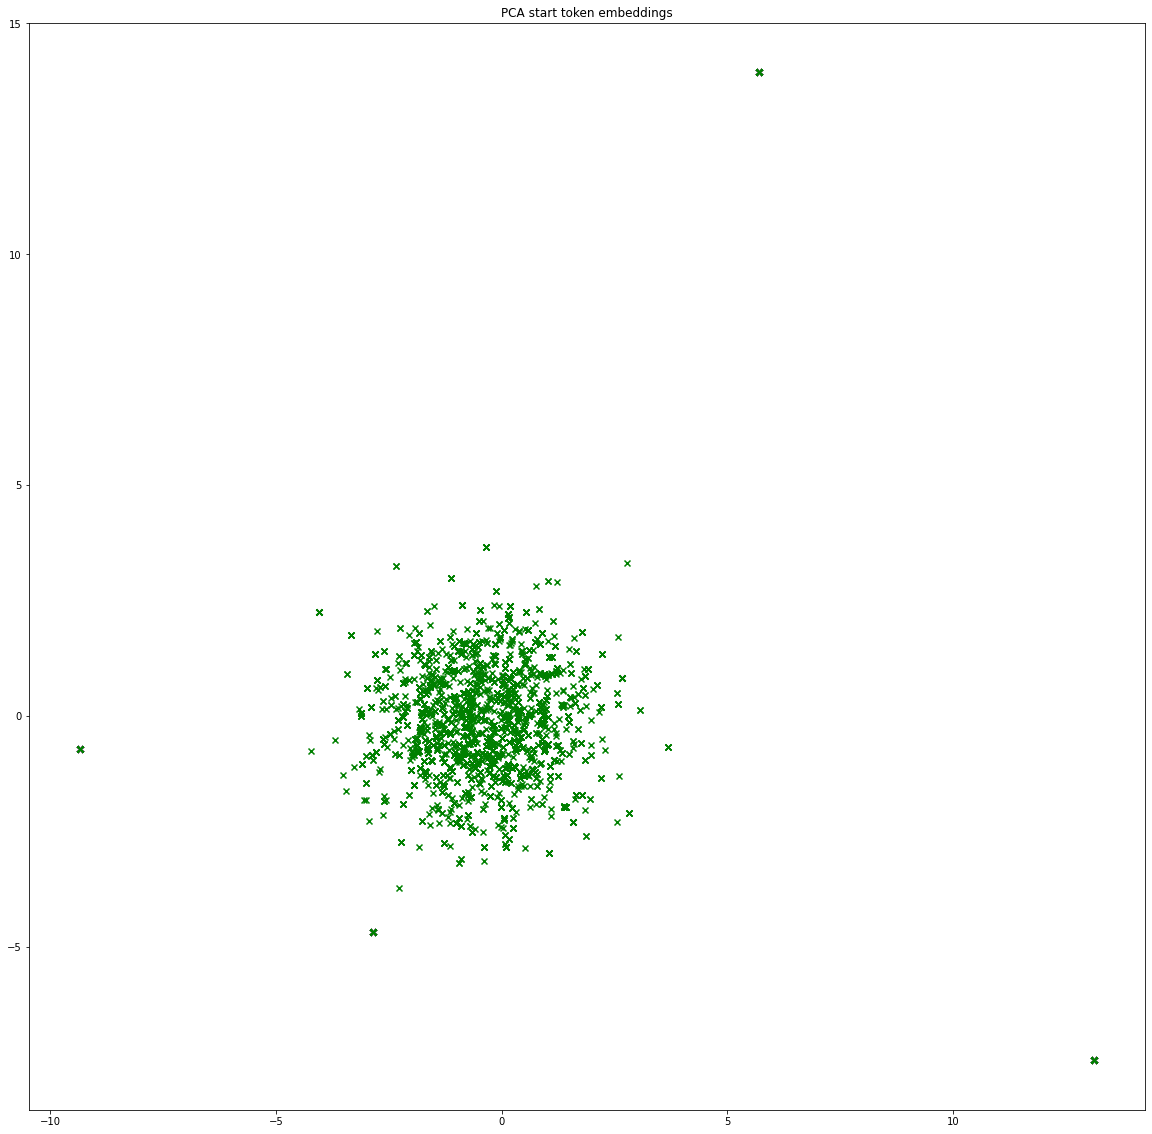

In [254]:
from matplotlib import pyplot as plt


plt.title('PCA start token embeddings')
plt.scatter(start_pca[:,0], start_pca[:,1],  marker="x", color="green")
plt.rcParams["figure.figsize"]=(20,20)
plt.show()


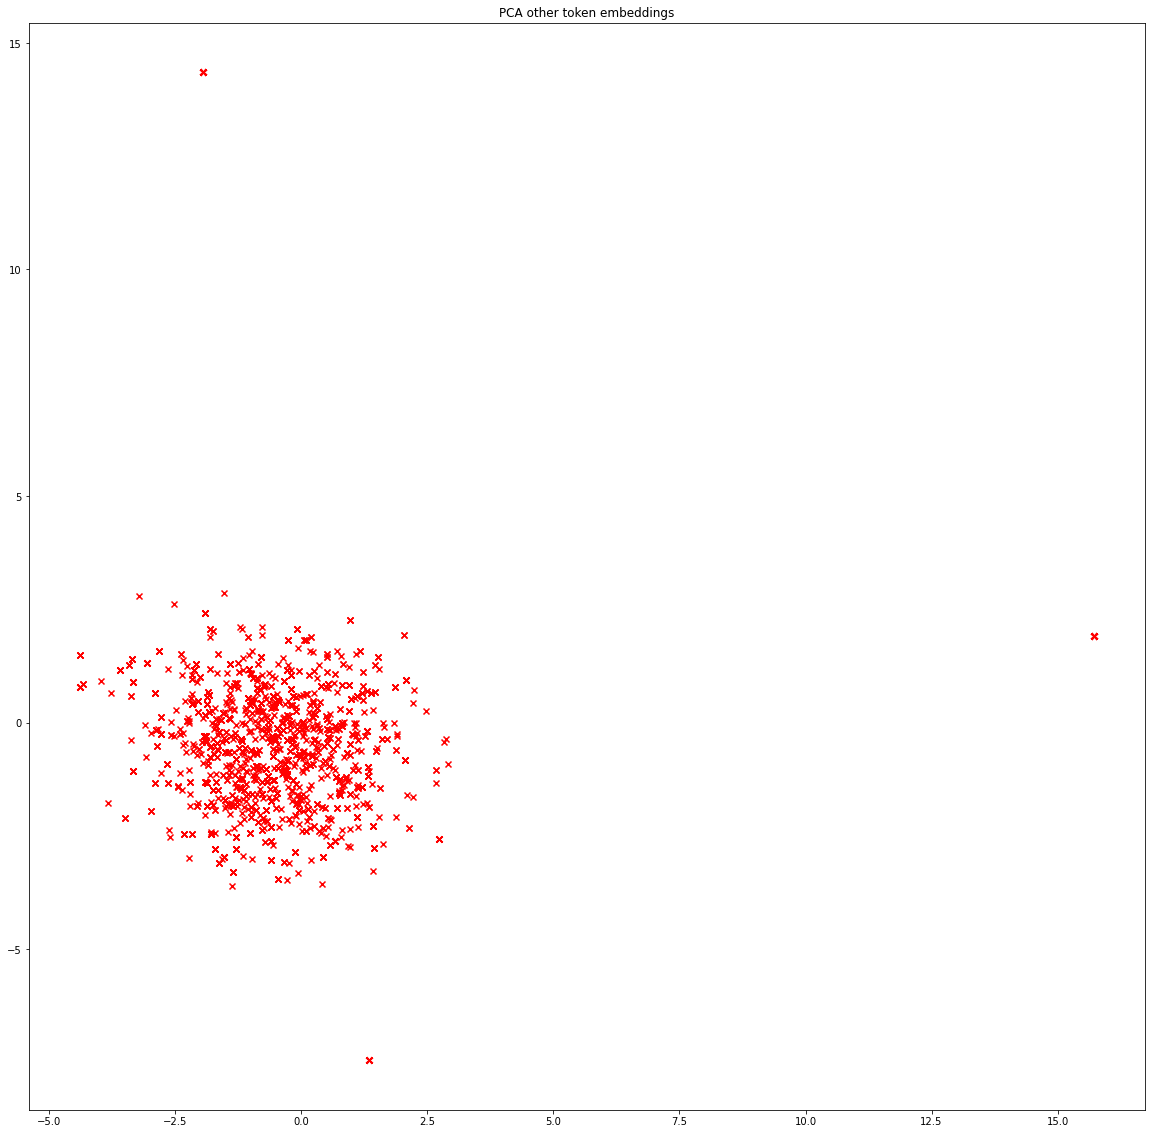

In [255]:
#other characters

plt.title('PCA other token embeddings')
plt.scatter(other_pca[:,0], other_pca[:,1], marker="x", color="red")
plt.rcParams["figure.figsize"]=(20,20)
plt.show()

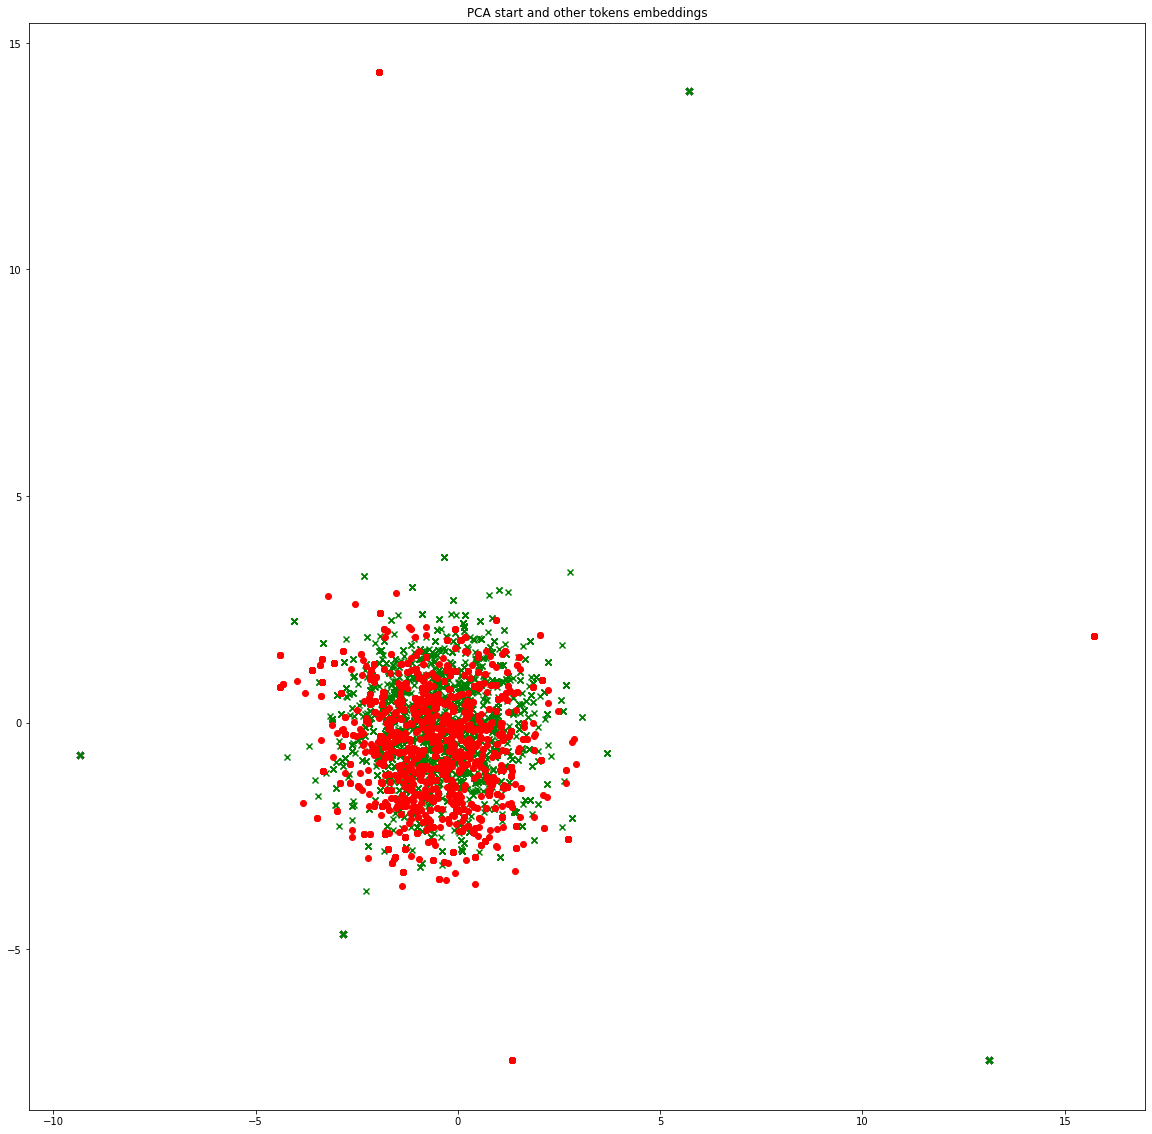

In [256]:
#both in same plot

plt.title('PCA start and other tokens embeddings')
plt.scatter(start_pca[:,0], start_pca[:,1],  marker="x", color="green")
plt.scatter(other_pca[:,0], other_pca[:,1], color="red")
plt.rcParams["figure.figsize"]=(20,20)
plt.show()

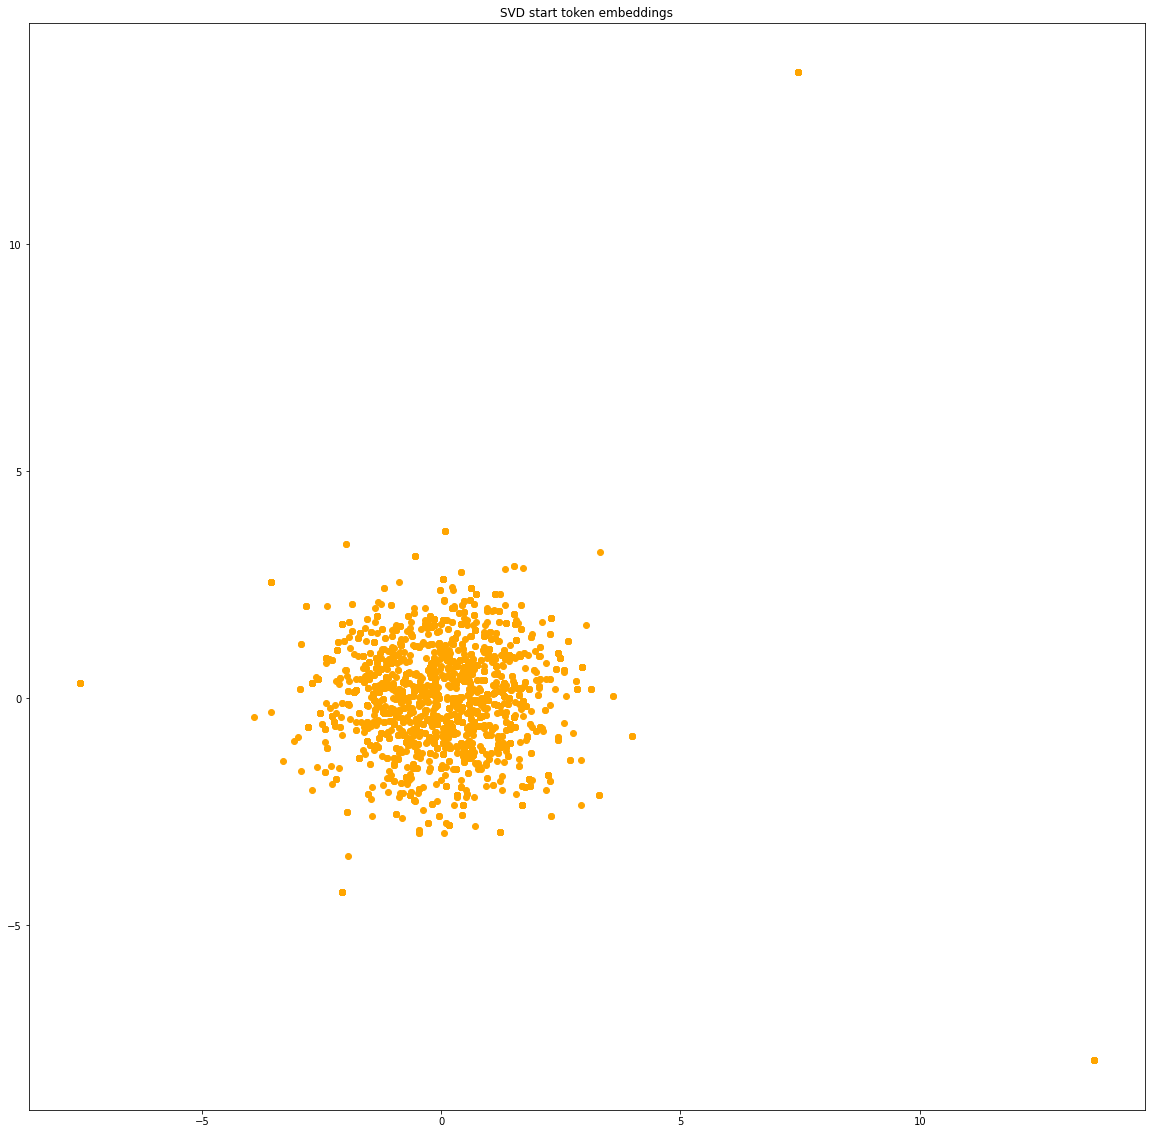

In [259]:
#start words svd
start_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(start)
plt.figure(figsize=(20,20))
plt.title('SVD start token embeddings')
plt.scatter(start_svd[:,0], start_svd[:,1], color="orange")



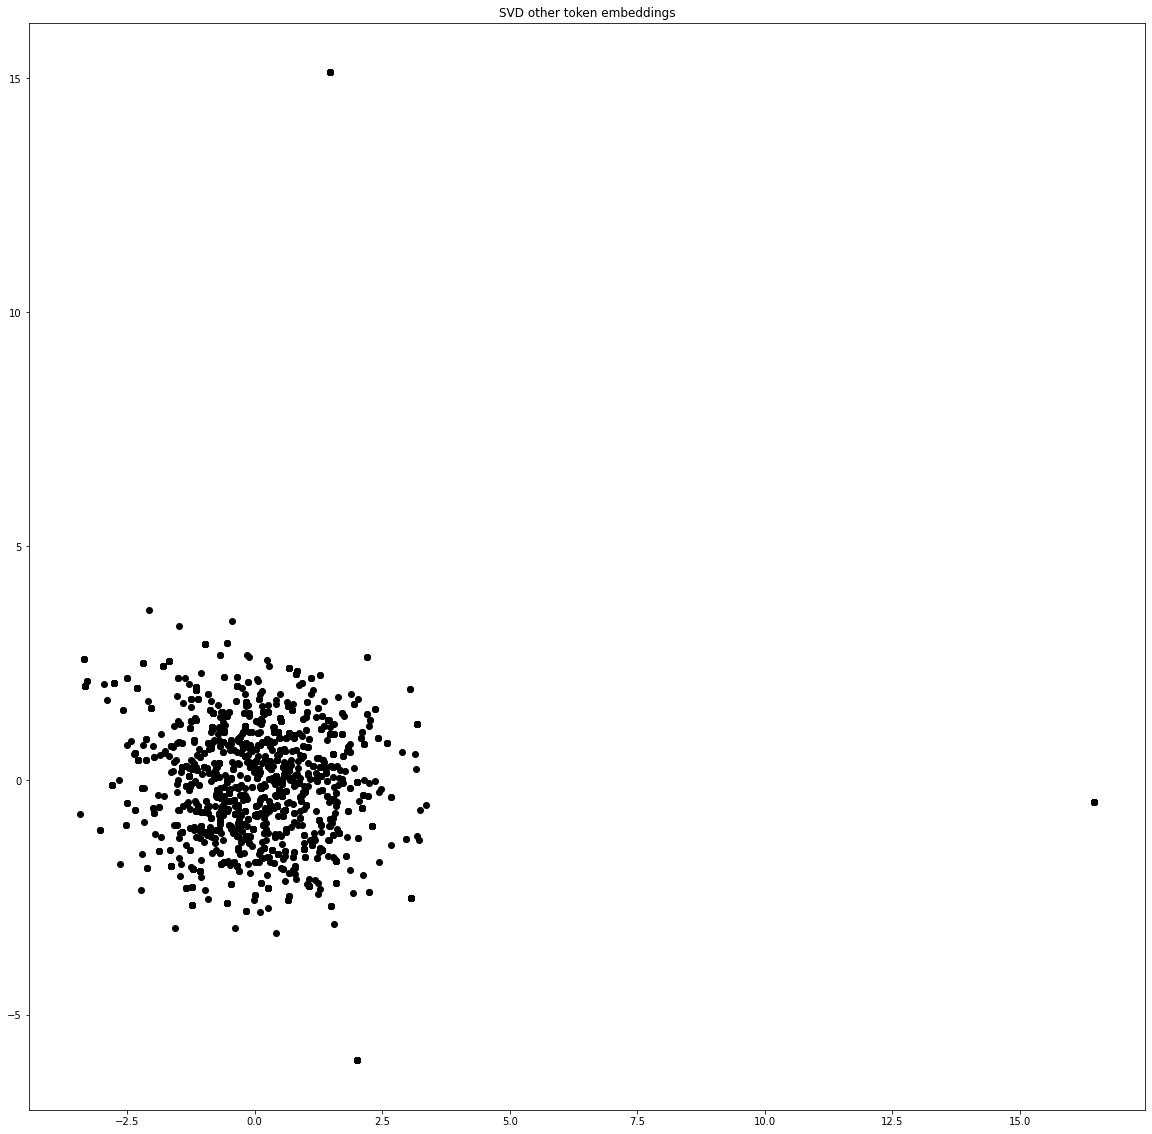

In [260]:
#other words svd
other_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(other)
plt.figure(figsize=(20,20))
plt.title('SVD other token embeddings')
plt.scatter(other_svd[:,0], other_svd[:,1], color="black")
